In [267]:
# DDPM学习以及数据集的可视化参考：https://www.bilibili.com/video/BV1b541197HX/

import torch
import torch.nn as nn
import numpy as np
from sklearn.datasets import make_s_curve # https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_s_curve.html
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

shape of s: (10000, 2)


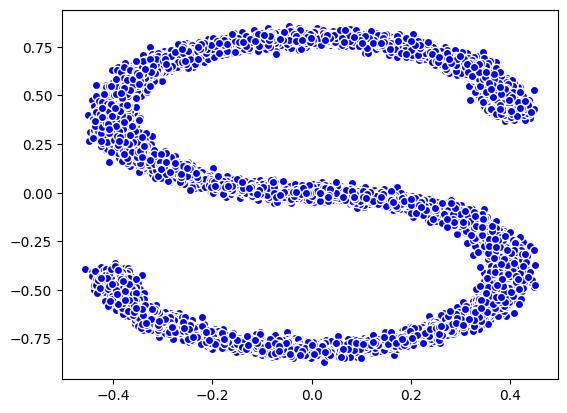

In [268]:
# 理解数据集：
# 真实2d数据分布：在s形上均匀分布，x轴 ~ [-1, 1], y轴 ~ [-2, 2]，我们用make_s_curve引入噪声采样1w个点
# make_s_curve源码：https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/_samples_generator.py

s_curve, _ = make_s_curve(int(1e4), noise = 0.05)
s_curve = s_curve[:, [0, 2]] / 2.5 # 用0维和2维降维到二维
print("shape of s:", s_curve.shape)

plt.scatter(*s_curve.T, color='blue', edgecolor='white')
plt.show()


In [269]:
# 理解超参数

NUM_STEPS = 100

# betas = 1 / np.linspace(NUM_STEPS, 1, num=NUM_STEPS, dtype=np.float64)
betas = np.linspace(-6, 6, num=NUM_STEPS, dtype=np.float32)
betas = 0.5 / (1 + np.exp(-betas))
print(f"betas: {betas}")
# 从经验主义出发，我们在越靠后的step中，采用越大的beta。
# 分析：越靠后的step，数据越来越趋近于噪声，此时我们倾向于加速噪声收敛；而越靠前的step，数据则应该倾向于保留原来的分布，选择更小的加噪幅度
alphas = 1 - betas
alpha_bars = np.cumprod(alphas)

assert betas.shape == (NUM_STEPS, )

betas: [0.00123631 0.00139518 0.00157441 0.00177657 0.00200459 0.00226174
 0.00255171 0.00287864 0.00324719 0.00366257 0.00413064 0.00465798
 0.00525192 0.00592069 0.00667347 0.00752052 0.00847322 0.00954427
 0.01074775 0.01209924 0.01361594 0.0153168  0.0172226  0.01935606
 0.02174191 0.0244069  0.02737985 0.03069155 0.0343747  0.0384636
 0.04299399 0.04800247 0.05352607 0.05960147 0.06626408 0.07354711
 0.08148023 0.0900883  0.0993898  0.10939536 0.12010621 0.13151269
 0.14359294 0.15631215 0.16962181 0.18345982 0.197751   0.21240844
 0.22733513 0.24242657 0.25757343 0.27266487 0.28759158 0.30224898
 0.31654018 0.33037817 0.34368786 0.35640705 0.36848733 0.37989378
 0.39060465 0.4006102  0.40991172 0.4185198  0.42645288 0.4337359
 0.4403985  0.4464739  0.45199755 0.45700604 0.4615364  0.46562532
 0.46930847 0.47262016 0.4755931  0.4782581  0.48064396 0.48277742
 0.48468322 0.4863841  0.4879008  0.48925227 0.49045575 0.49152675
 0.4924795  0.49332651 0.49407932 0.4947481  0.49534202 0

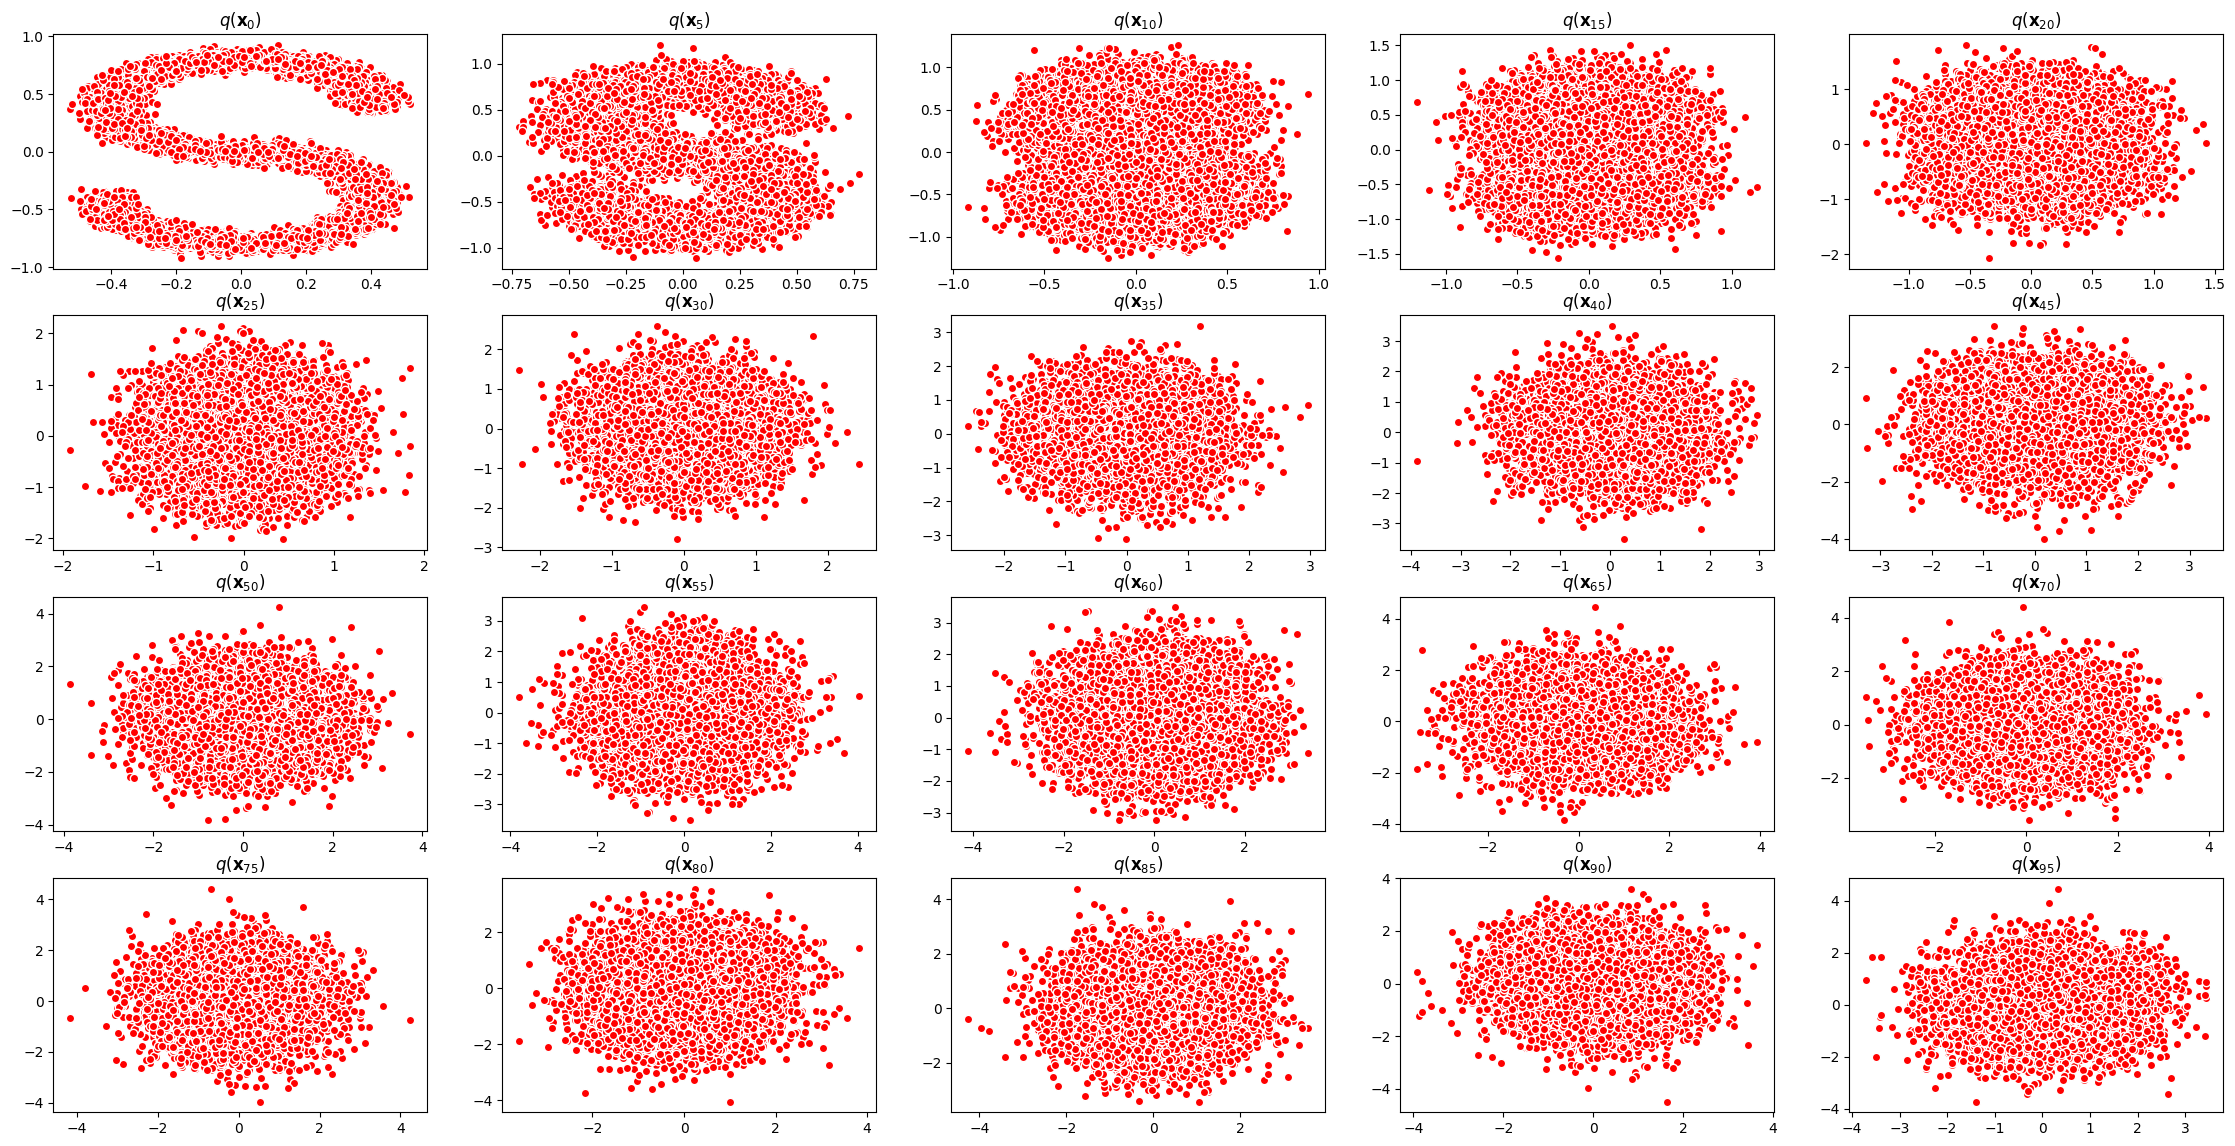

In [270]:
# Forward process 前进过程（加噪）
# calculating the sampling of xt based on x0 and reparameterization
def q_x(x_0, t):
    noise = np.random.normal(size=x_0.shape)
    alpha_bar_t = alpha_bars[t]
    return (np.sqrt(alpha_bar_t) * x_0 + np.sqrt(1.0 - alpha_bar_t) * noise)

# Visualization
num_rows = 4
num_fig_per_row = 5
num_figures = num_rows * num_fig_per_row
fig, axs = plt.subplots(4, 5, figsize=(28, 14))

for i in range(num_figures):
    row_id = i // num_fig_per_row
    column_id = i % num_fig_per_row
    q_i = q_x(s_curve, int(i * NUM_STEPS / num_figures))
    axs[row_id][column_id].scatter(*q_i.T, color='red', edgecolor='white')
    axs[row_id][column_id].set_title('$q(\mathbf{x}_{' + str(i * NUM_STEPS // num_figures) + '})$')

In [271]:
# 降噪神经网络
# 输入：时刻t，以及时刻t的数据（这个case为2维数据）
# 输出：简单理解为预测时刻t p降噪分布（q加噪后验分布）的高斯噪声的均值，实际则是直接预测t时刻加噪时的累计重参化噪声，通过预测出的噪声算出p降噪分布均值
# Loss: 噪声MSE Loss! (Mean Squared Error)
# 结构设计：最简单的3隐层MLP结构

class MLPDiffusion(nn.Module):
    def __init__(self, num_steps, input_dim, hidden_size=128):
        """
        @params:
            num_steps: 扩散步数
            input_dim: 输入维度
            hidden_size: 隐层维度
        """
        super(MLPDiffusion, self).__init__()
        self.num_steps = num_steps

        self.linear1 = nn.Linear(input_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, input_dim)
        self.embedding1 = nn.Embedding(num_steps, hidden_size)
        self.embedding2 = nn.Embedding(num_steps, hidden_size)
        self.embedding3 = nn.Embedding(num_steps, hidden_size)
        self.activation_fn = nn.ReLU()

    def forward(self, x, t):
        """
        @params:
            t: num_steps中的第t个step
            x: t时刻输入
        """
        # 1
        x = self.linear1(x)
        t_embedding = self.embedding1(t)
        x = x + t_embedding
        x = self.activation_fn(x)
        # 2
        x = self.linear2(x)
        t_embedding = self.embedding2(t)
        x = x + t_embedding
        x = self.activation_fn(x)
        # 3
        x = self.linear3(x)
        t_embedding = self.embedding3(t)
        x = x + t_embedding
        x = self.activation_fn(x)
        # 4
        x = self.linear4(x)
        return x

In [272]:
# 训练 批数据 前进过程，返回噪声用于loss，以及t时刻的数据用于送进模型
def batch_forward_diffusion(x_0):
    # 送入一个batch的数据
    batch_size = x_0.shape[0]
        
    # 为batch里面的每个数据点，随机均匀采样一个t
    t = torch.randint(0, NUM_STEPS, size=(batch_size,))

    #x0 multiplier
    batch_alpha_bars = alpha_bars[t.unsqueeze(-1)] # 如果用np，用expand_dims函数，将一位数组拉成batch*1的形状
    a = torch.sqrt(batch_alpha_bars)
    
    #noise multiplier
    aml = torch.sqrt(1.0 - batch_alpha_bars)
    
    #generate random noise eps
    e = torch.from_numpy(np.random.normal(size=x_0.shape)).to(dtype=torch.float32)
    
    #combine x0 and noise
    x_t = a * x_0 + aml * e
    
    #calculate mean with noise
    return e, x_t, t

In [273]:
# loss
def loss_diffusion(model, e, x_t, t):
    e_theta = model(x_t.to(dtype=torch.float32), t)
    return nn.MSELoss()(e, e_theta)

In [274]:
# dataloader
BATCH_SIZE = 128
dataloader = torch.utils.data.DataLoader(s_curve, batch_size=BATCH_SIZE, shuffle=True)

# model
model = MLPDiffusion(NUM_STEPS, 2)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [281]:
# p sample (p 降噪分布)
# 模型得到的是噪声，需要转换成降噪分布的均值

def p_sample(model, x_t, t, betas, alpha_bars):
    t = torch.Tensor([t]).to(dtype=torch.int)
    coeff = betas[t] / np.sqrt(1 - alpha_bars[t])
    e_theta = model(x_t, t)
    z = torch.randn_like(x_t)
    miu_theta = (x_t - coeff * e_theta) / np.sqrt(1. - betas[t])
    sigma_t = np.sqrt(betas[t])
    return miu_theta + sigma_t * z

def p_sample_loop(model, sample_shape, betas, alpha_bars):
    x_T = torch.randn(sample_shape).to(dtype=torch.float32)
    x_seq = [x_T]
    x_i = x_T
    for i in range(NUM_STEPS-1, -1, -1):
        x_i = p_sample(model, x_i, i, betas, alpha_bars).detach()
        x_seq.append(x_i)
    return x_seq

tensor(0.1923, grad_fn=<MseLossBackward0>)


/tmp/ipykernel_5787/465961178.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  coeff = betas[t] / np.sqrt(1 - alpha_bars[t])
/tmp/ipykernel_5787/465961178.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  miu_theta = (x_t - coeff * e_theta) / np.sqrt(1. - betas[t])
/tmp/ipykernel_5787/465961178.py:10: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sigma_t = np.sqrt(betas[t])


tensor(0.1376, grad_fn=<MseLossBackward0>)
tensor(0.0512, grad_fn=<MseLossBackward0>)
tensor(0.3444, grad_fn=<MseLossBackward0>)
tensor(0.0700, grad_fn=<MseLossBackward0>)
tensor(0.3438, grad_fn=<MseLossBackward0>)
tensor(0.1003, grad_fn=<MseLossBackward0>)
tensor(0.1620, grad_fn=<MseLossBackward0>)
tensor(0.2149, grad_fn=<MseLossBackward0>)
tensor(0.4383, grad_fn=<MseLossBackward0>)
tensor(0.1925, grad_fn=<MseLossBackward0>)
tensor(0.2951, grad_fn=<MseLossBackward0>)
tensor(0.0705, grad_fn=<MseLossBackward0>)
tensor(0.0052, grad_fn=<MseLossBackward0>)
tensor(0.0270, grad_fn=<MseLossBackward0>)
tensor(0.3888, grad_fn=<MseLossBackward0>)
tensor(0.0539, grad_fn=<MseLossBackward0>)
tensor(0.1441, grad_fn=<MseLossBackward0>)
tensor(0.1168, grad_fn=<MseLossBackward0>)
tensor(0.1875, grad_fn=<MseLossBackward0>)


/tmp/ipykernel_5787/3329172827.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 10, figsize=(28, 3))


tensor(0.3393, grad_fn=<MseLossBackward0>)
tensor(0.1902, grad_fn=<MseLossBackward0>)
tensor(0.0599, grad_fn=<MseLossBackward0>)
tensor(0.0417, grad_fn=<MseLossBackward0>)
tensor(0.0974, grad_fn=<MseLossBackward0>)
tensor(0.1389, grad_fn=<MseLossBackward0>)
tensor(0.1323, grad_fn=<MseLossBackward0>)
tensor(0.5089, grad_fn=<MseLossBackward0>)
tensor(0.1043, grad_fn=<MseLossBackward0>)


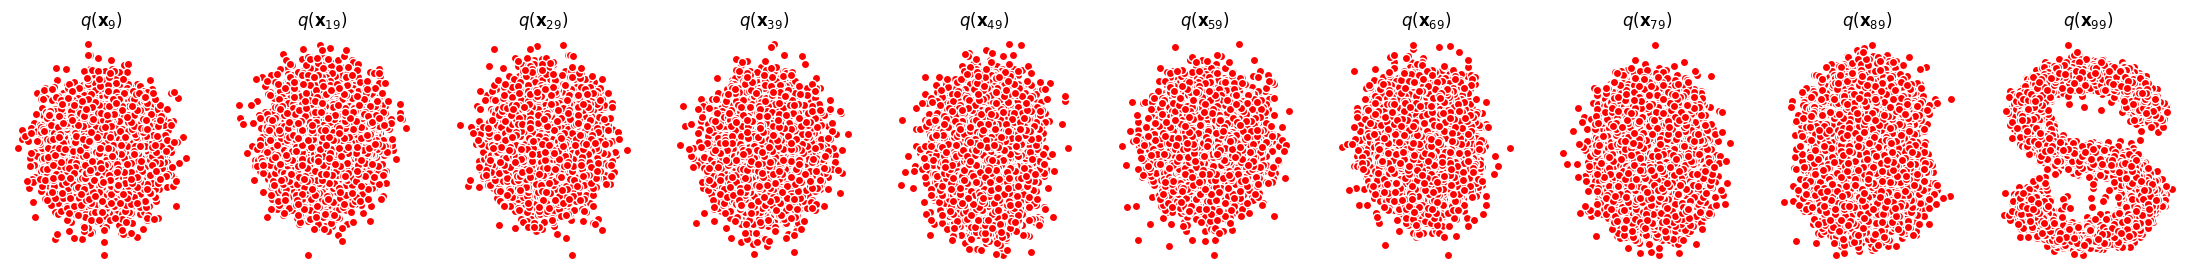

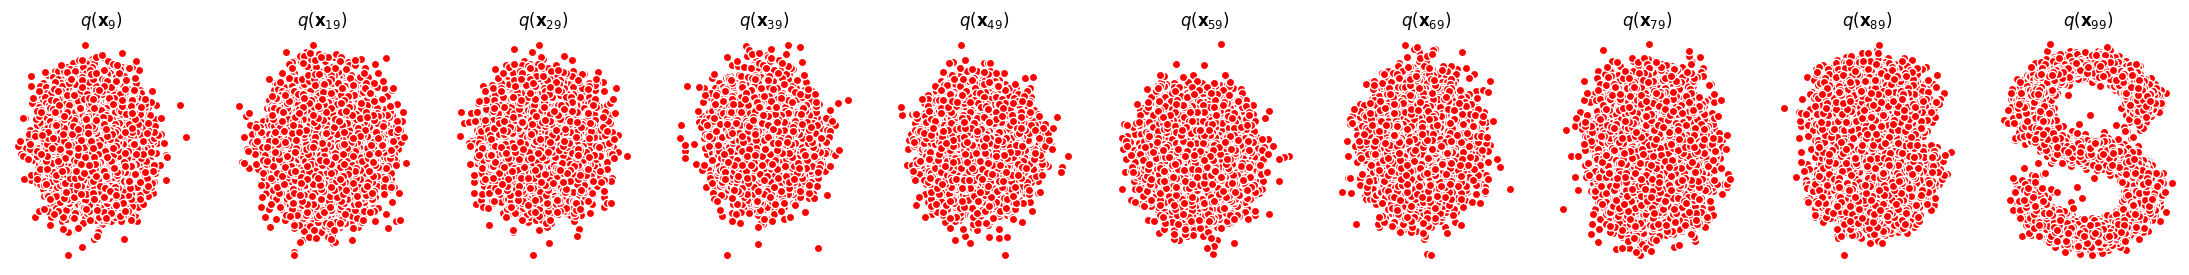

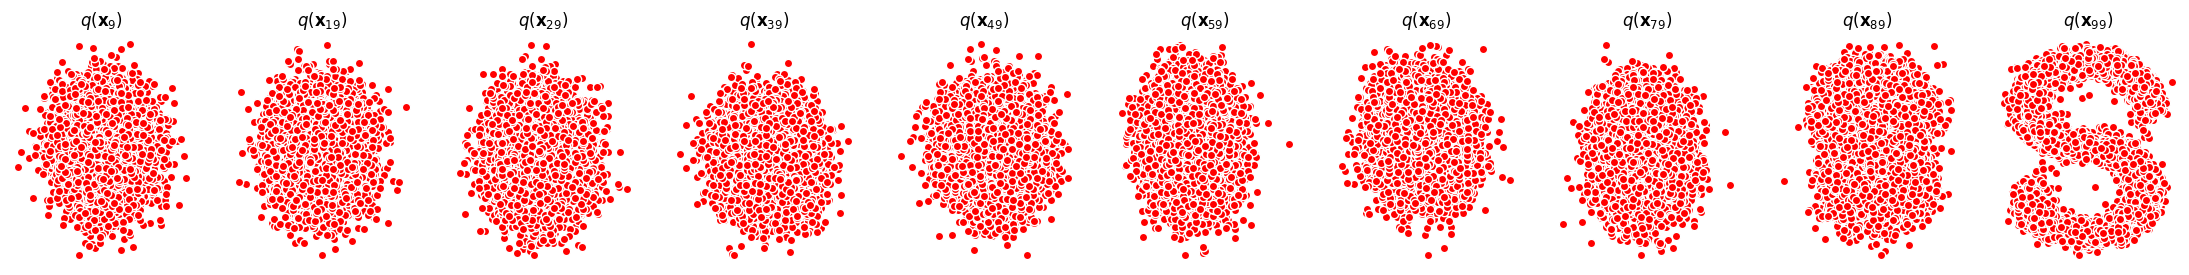

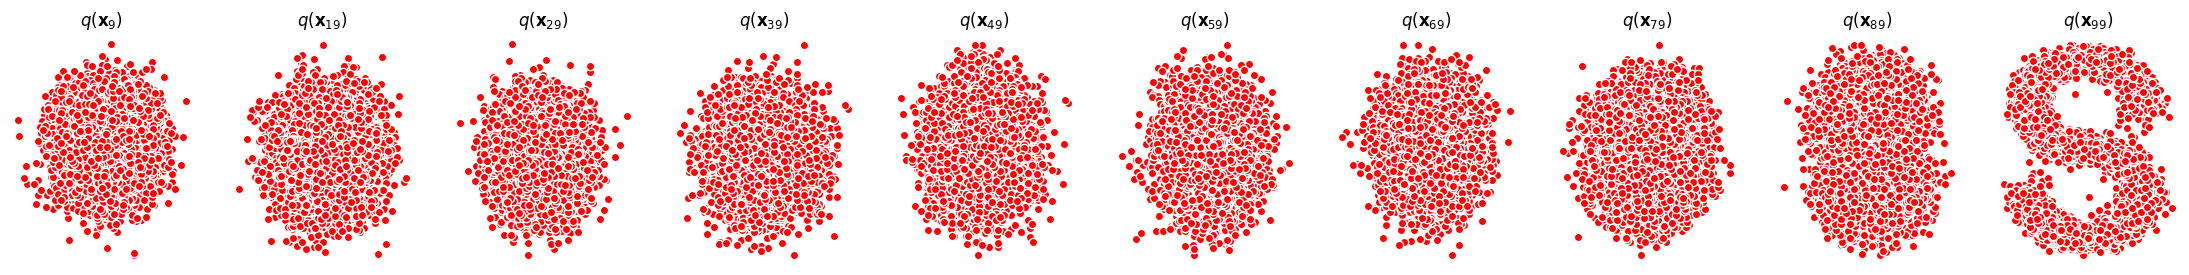

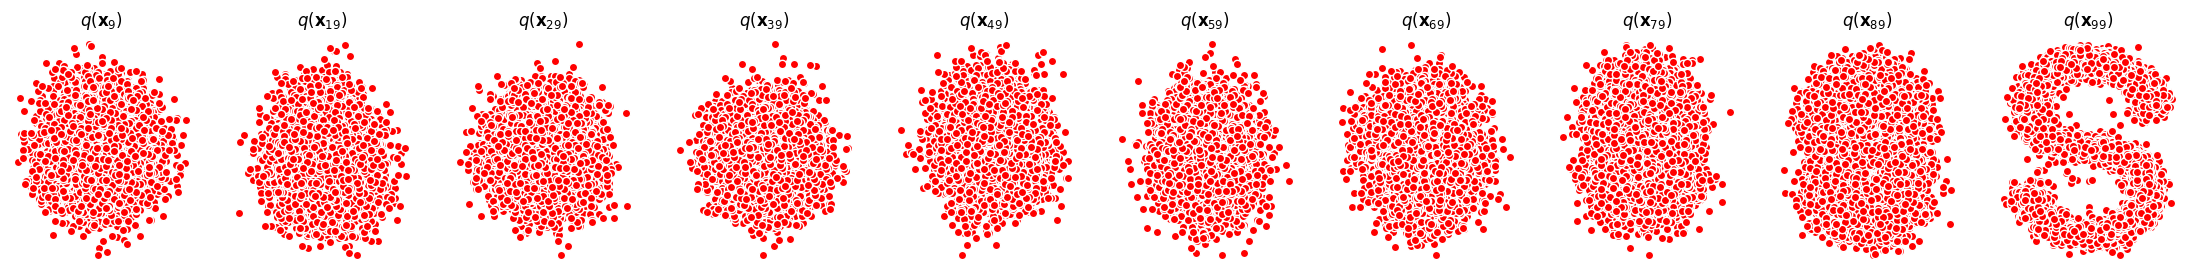

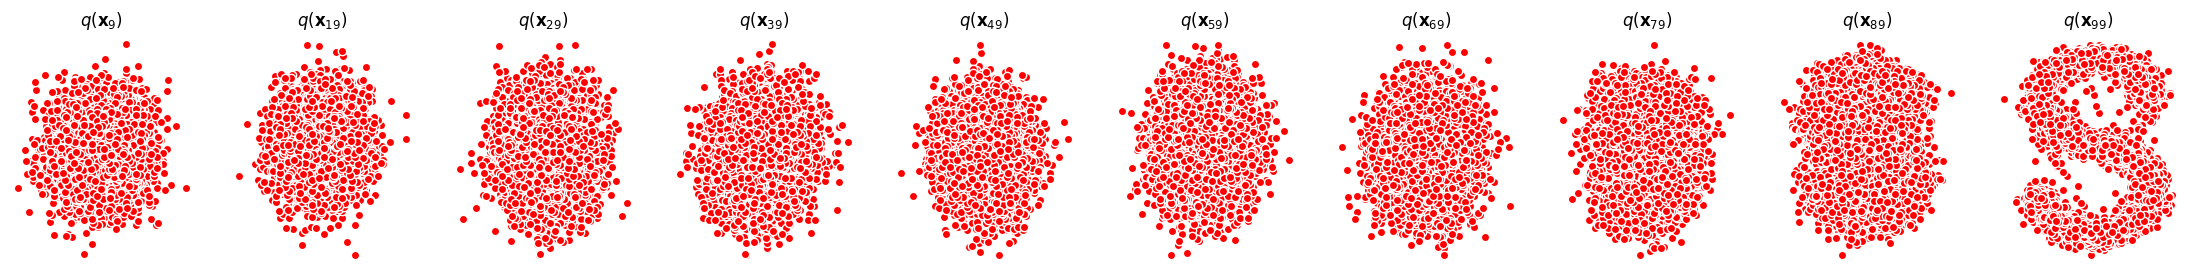

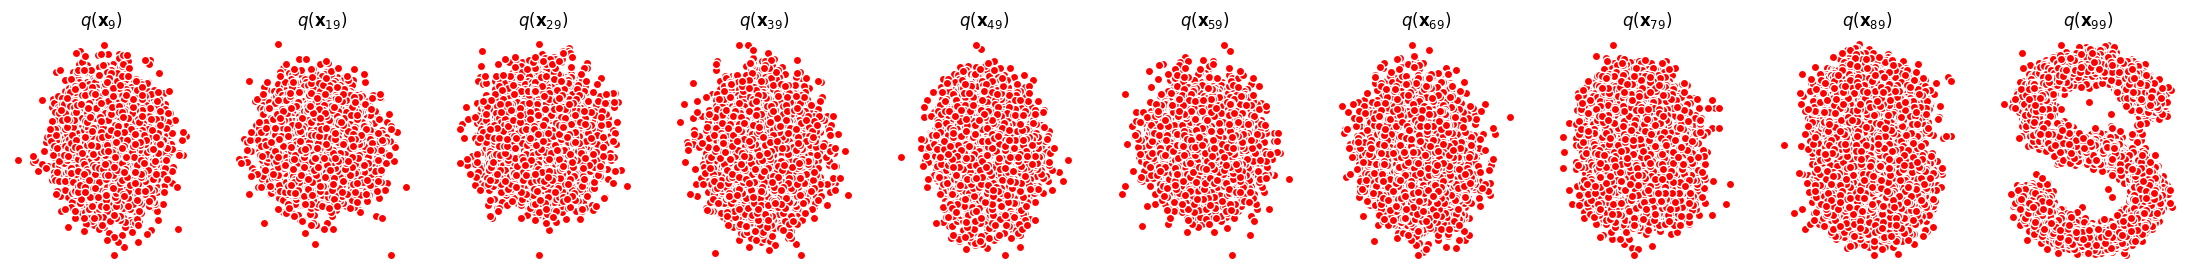

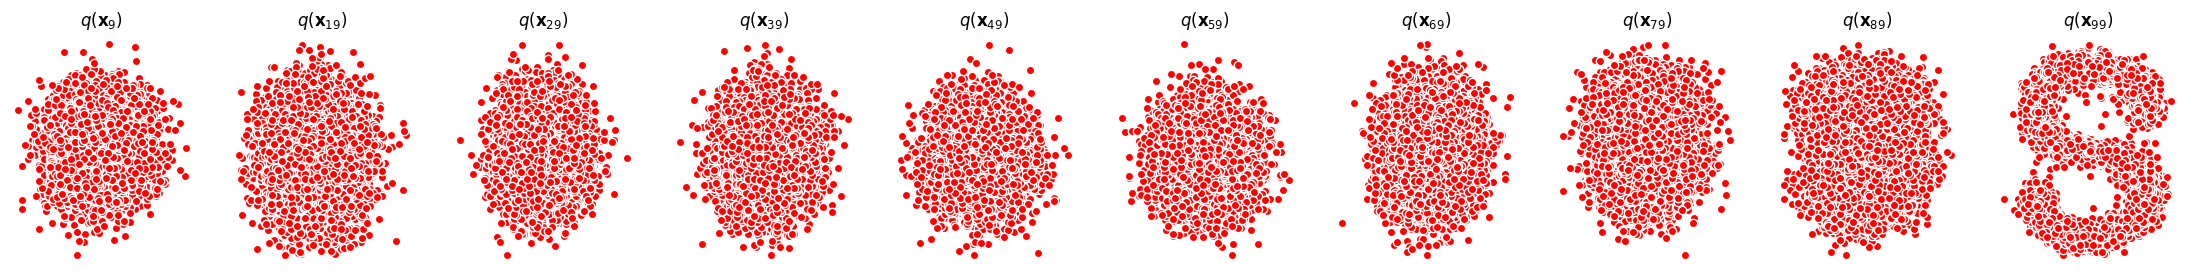

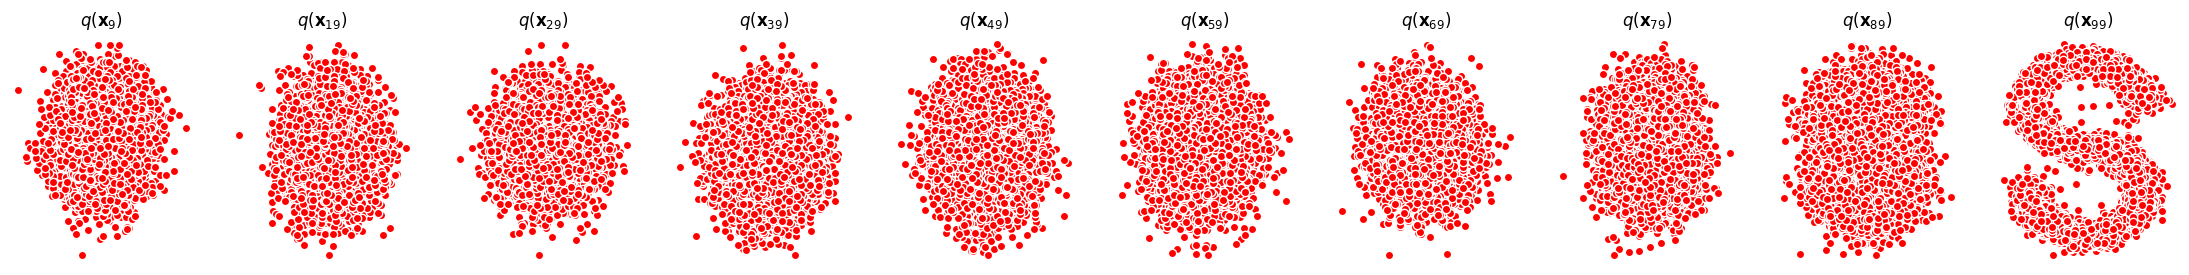

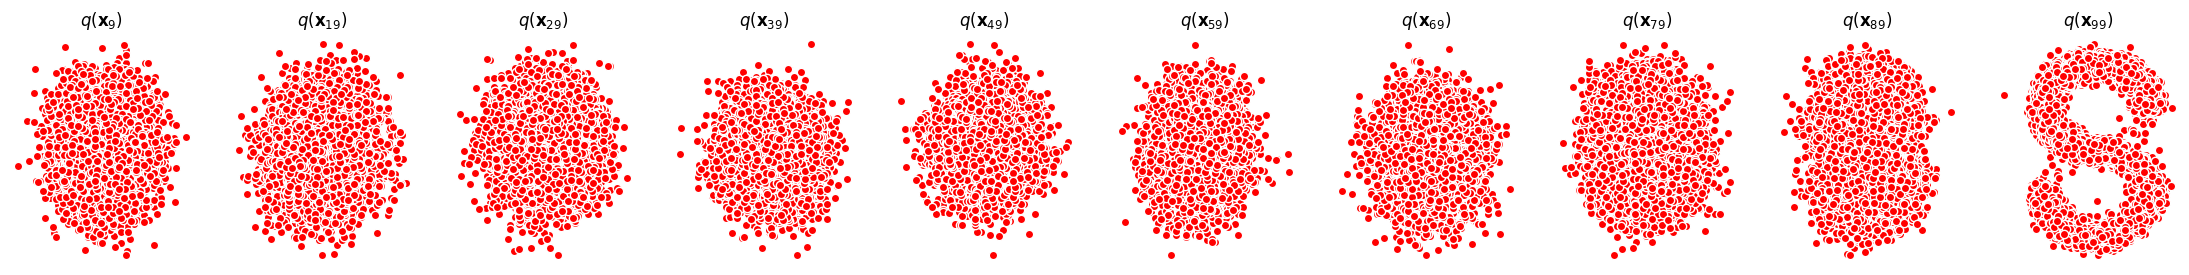

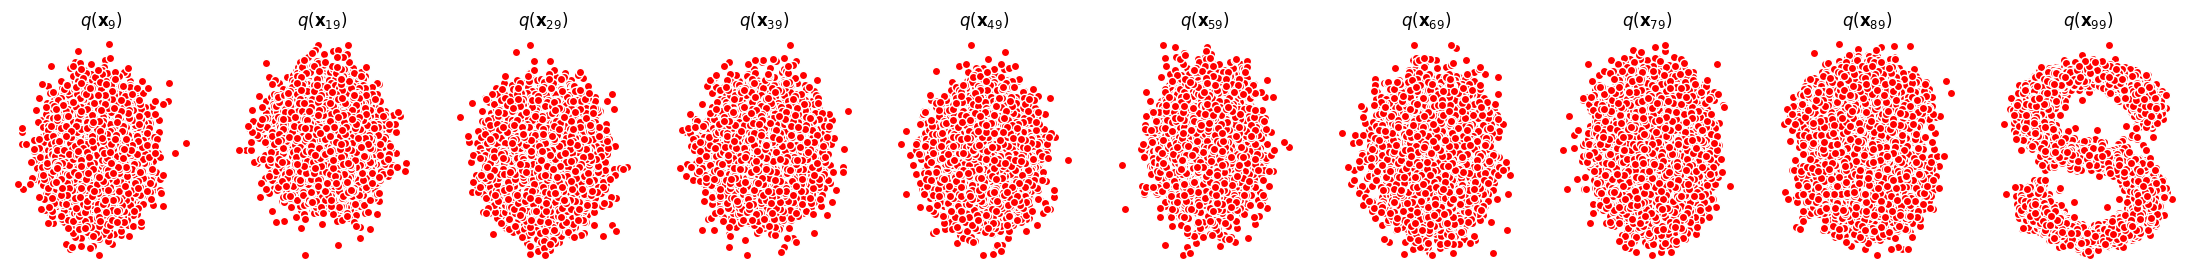

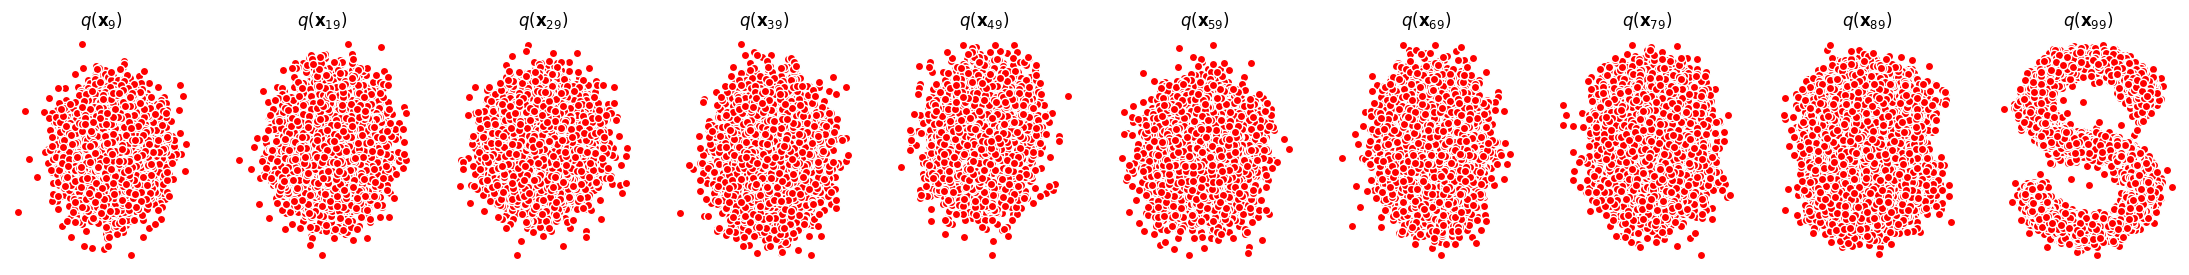

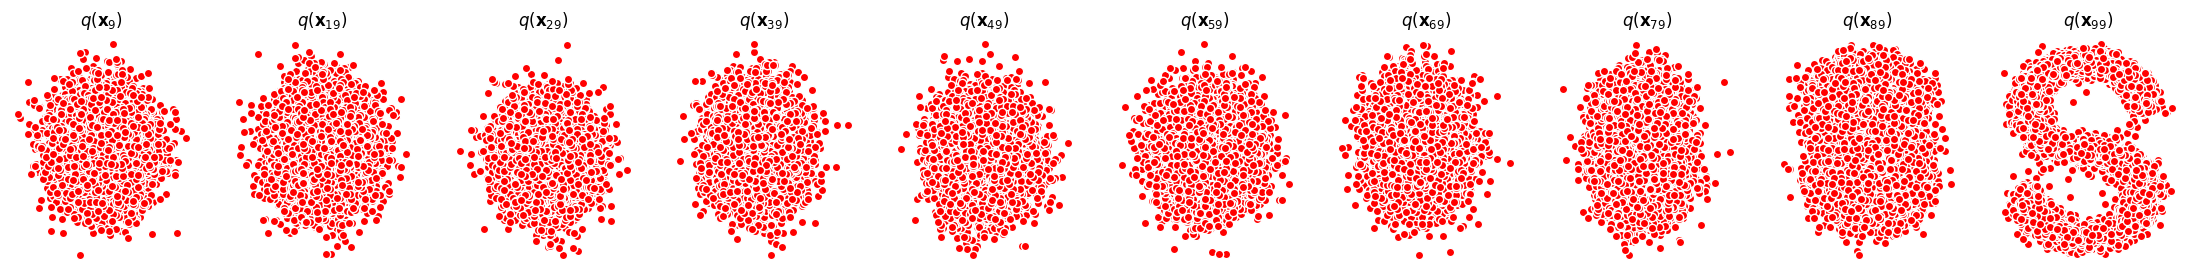

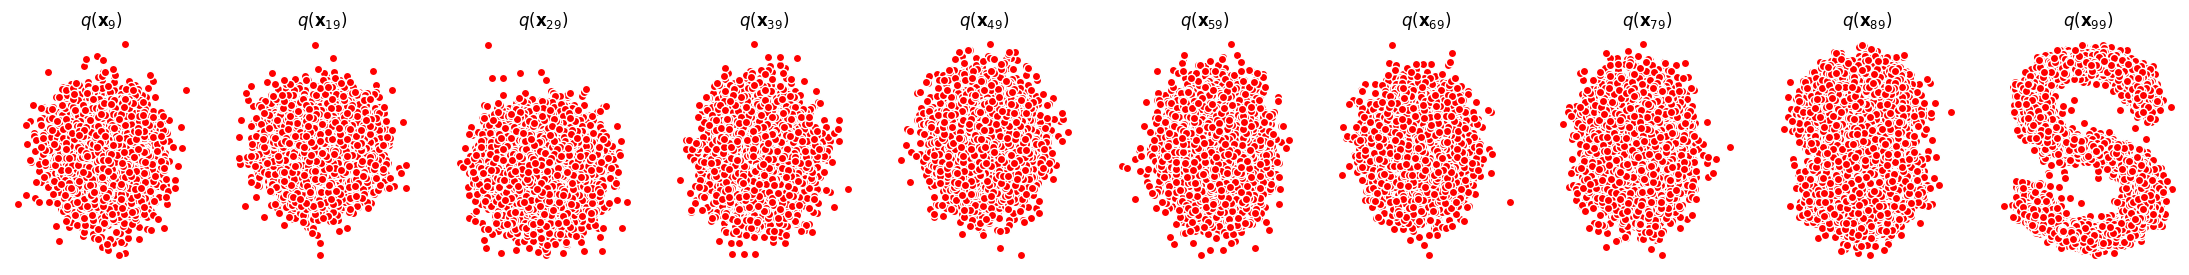

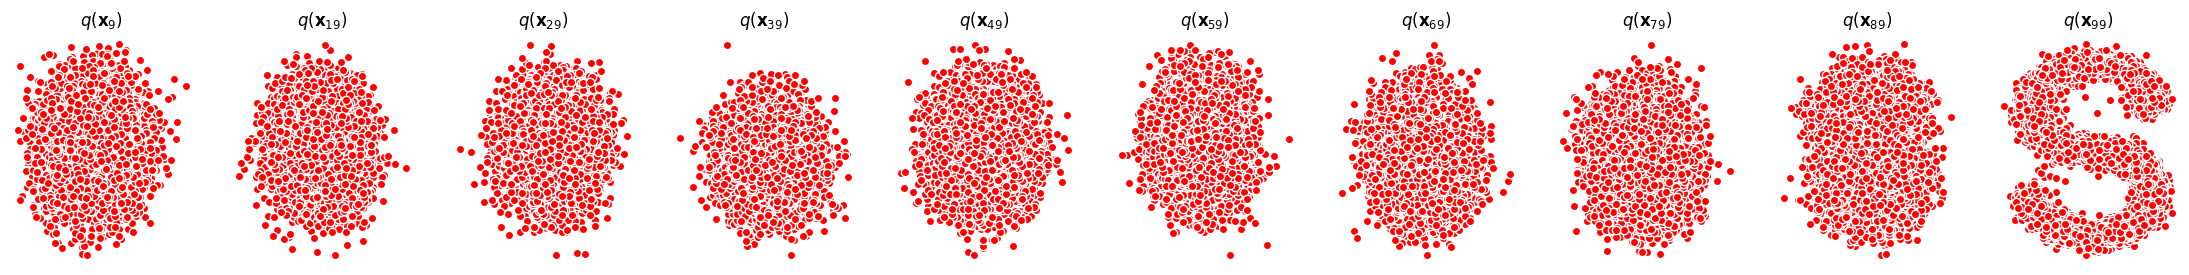

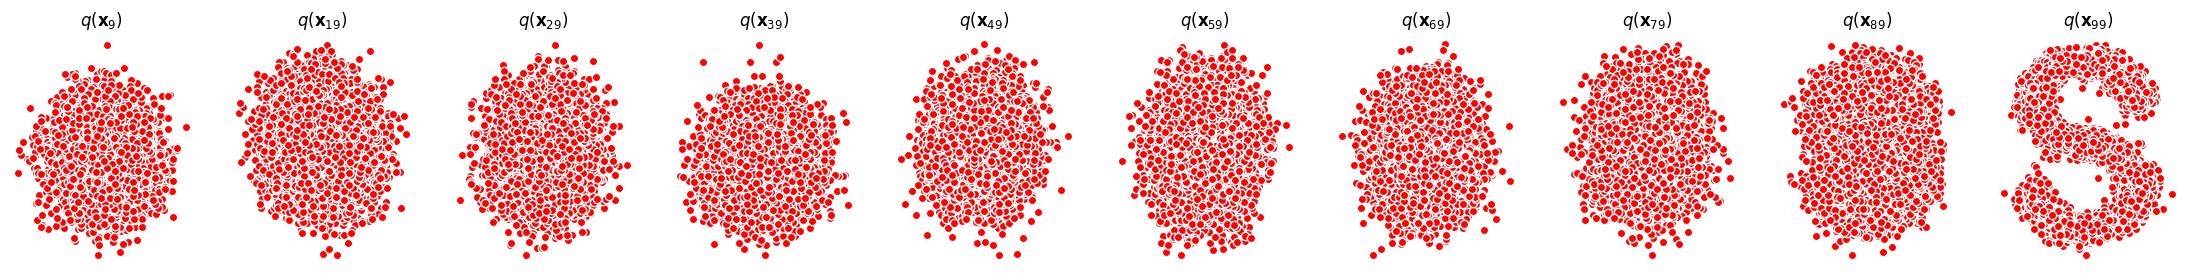

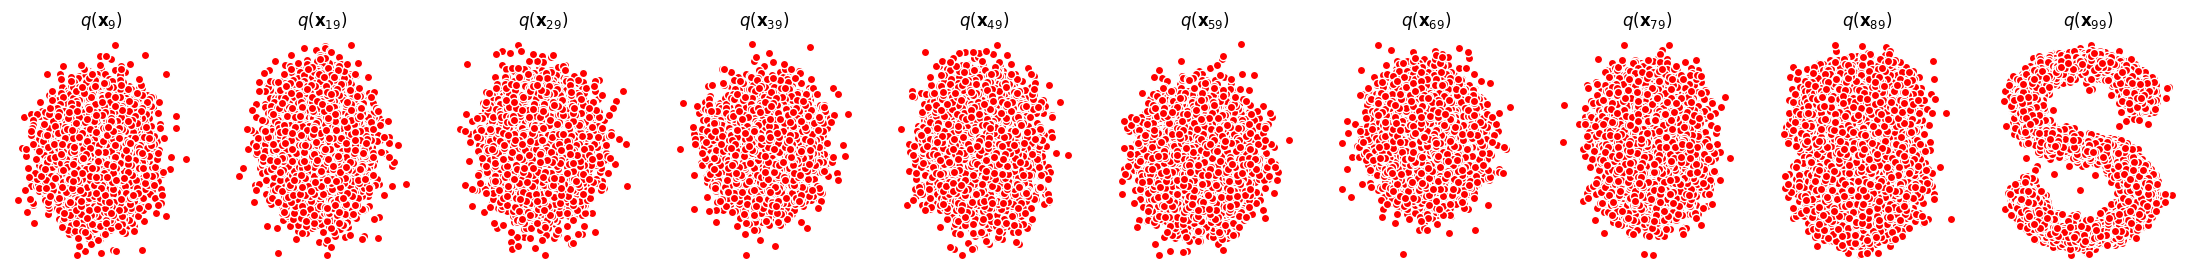

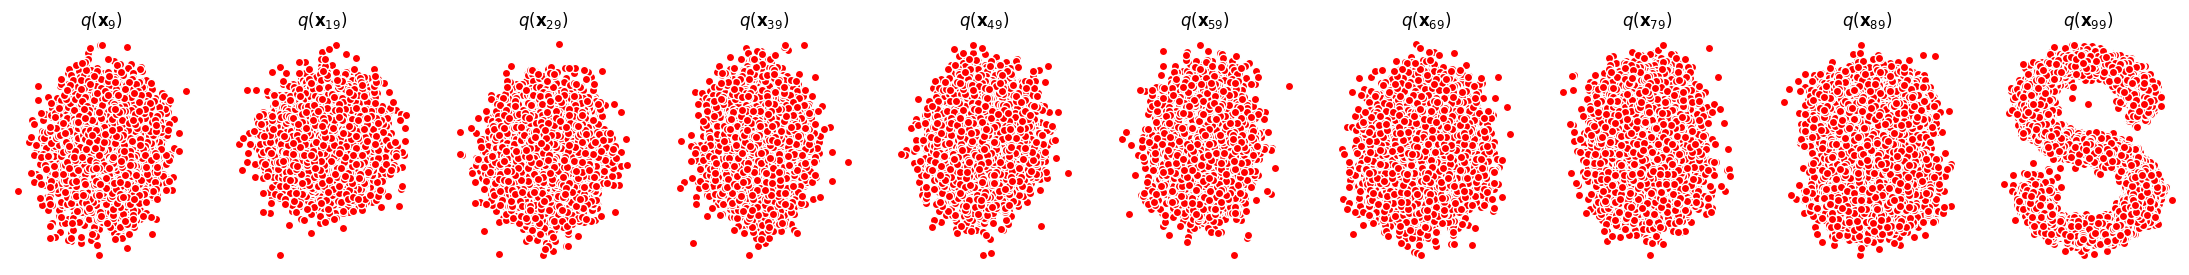

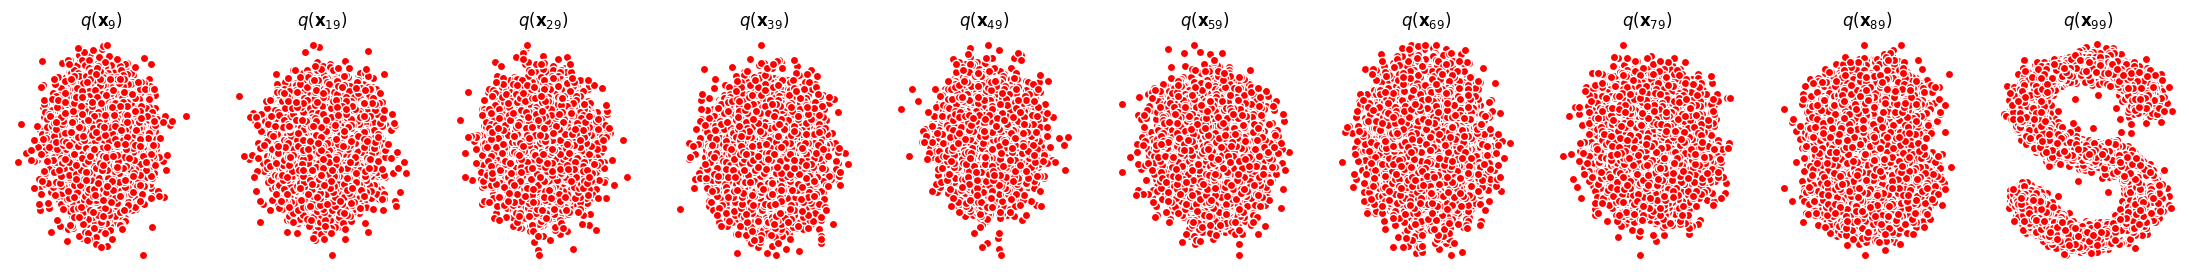

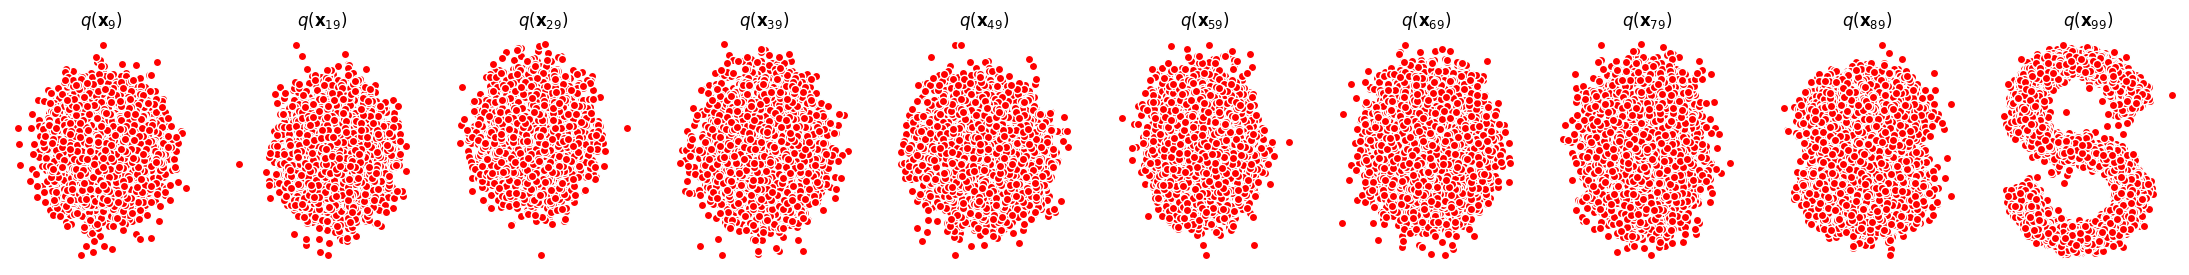

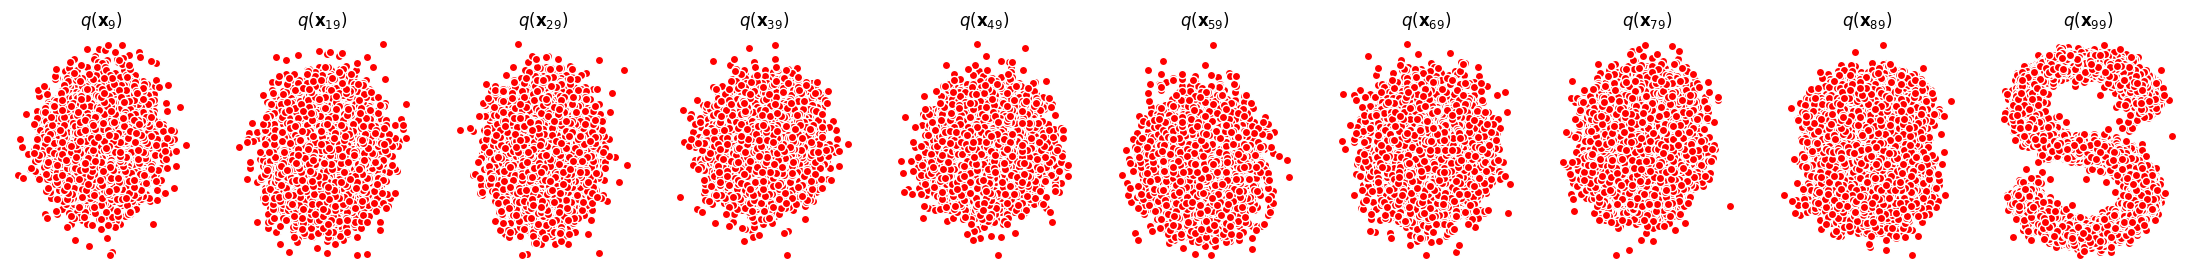

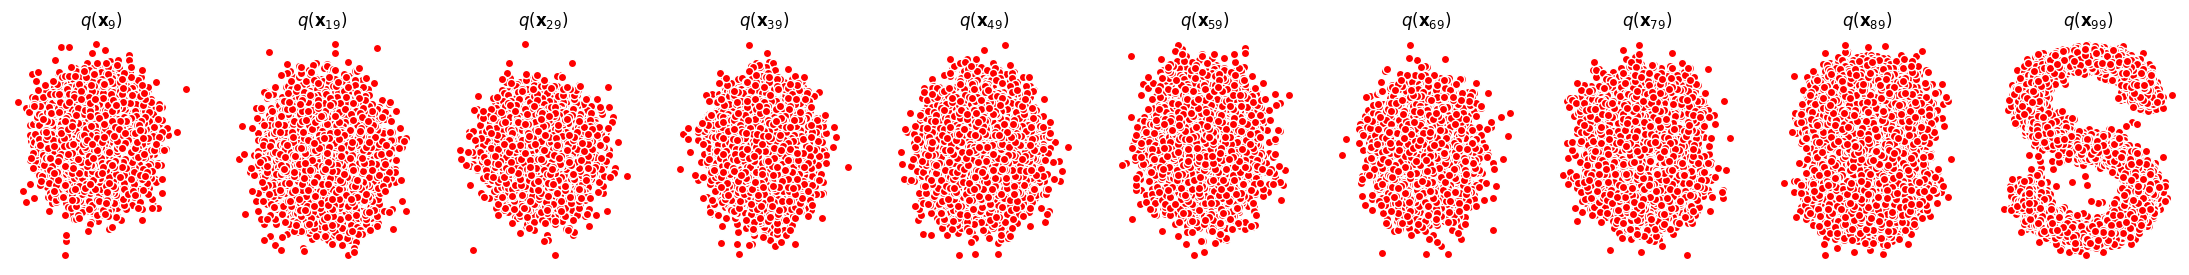

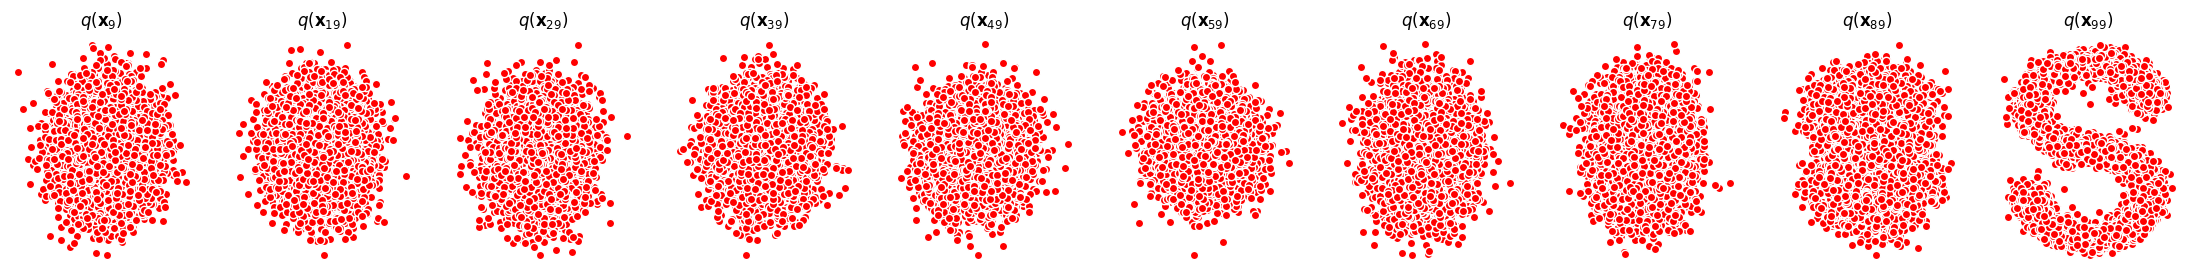

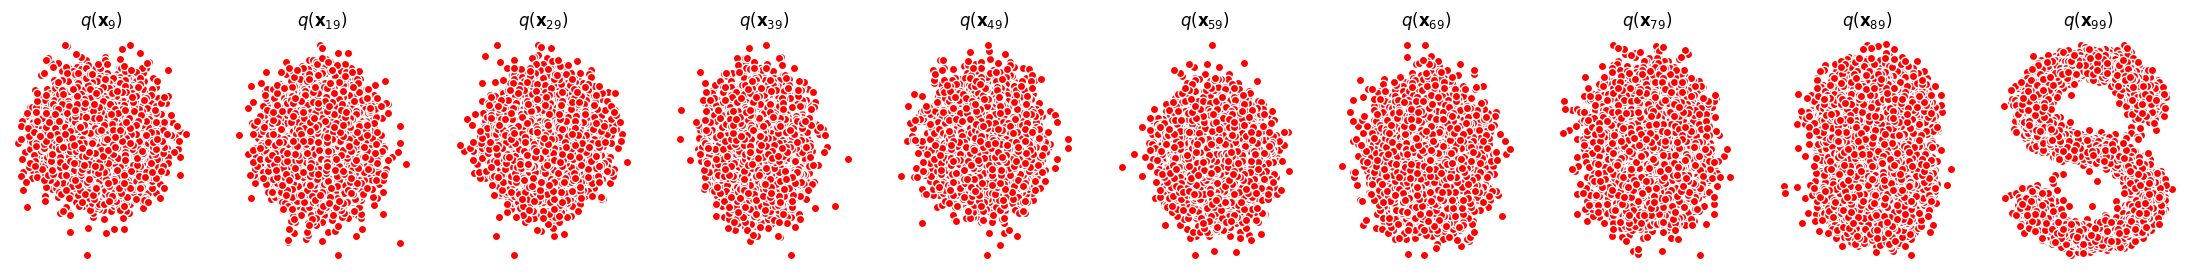

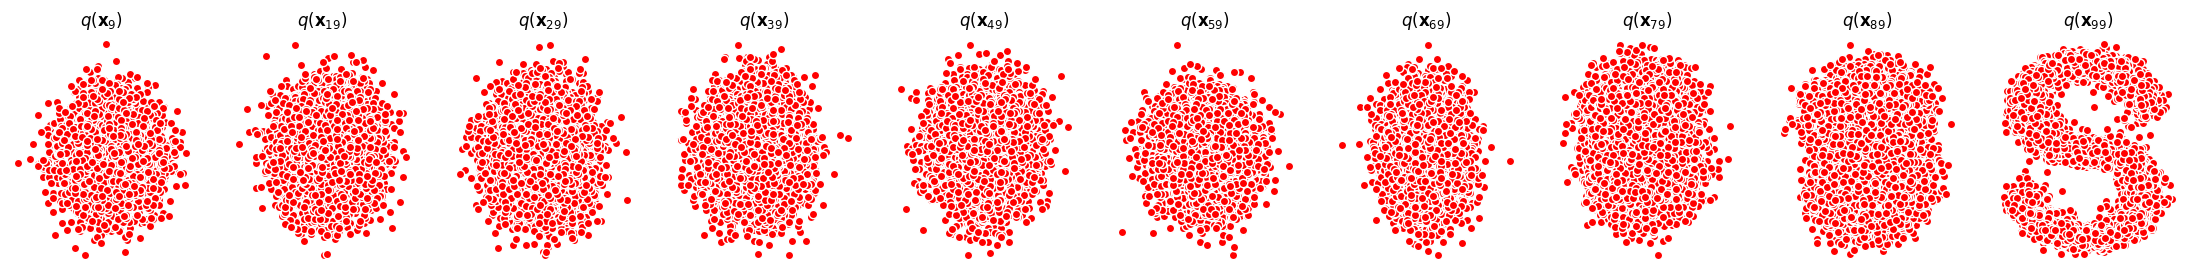

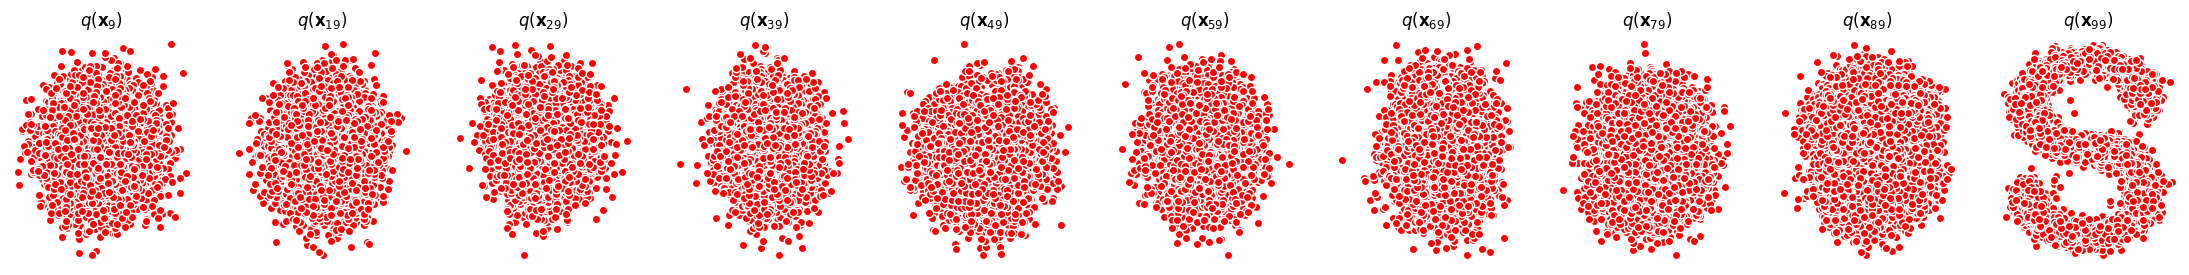

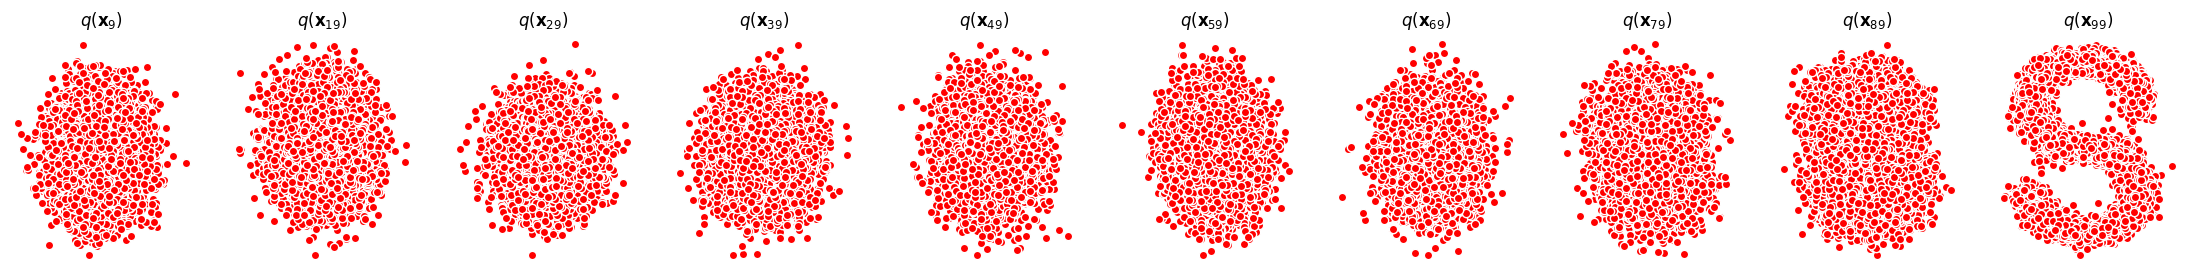

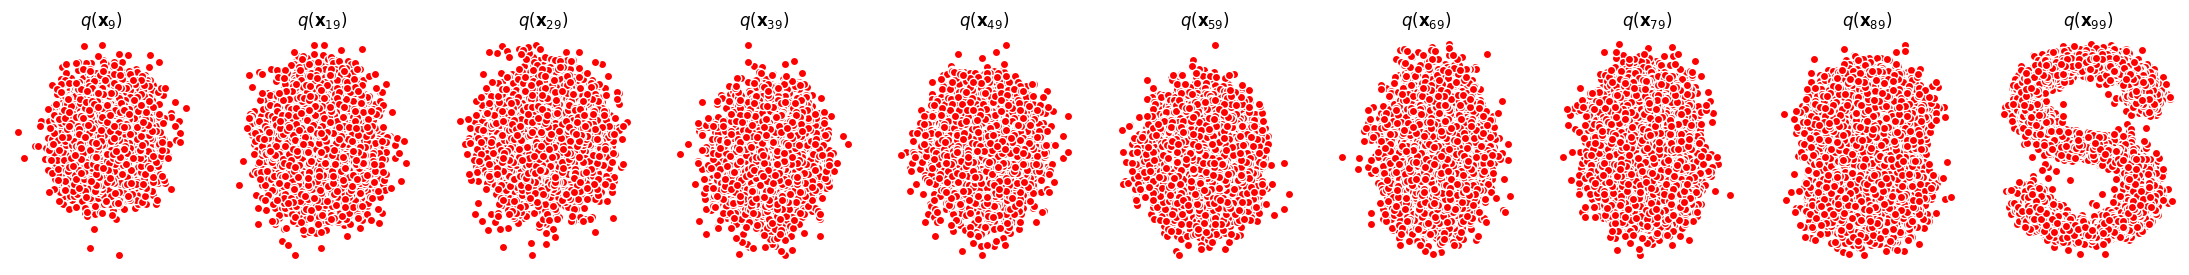

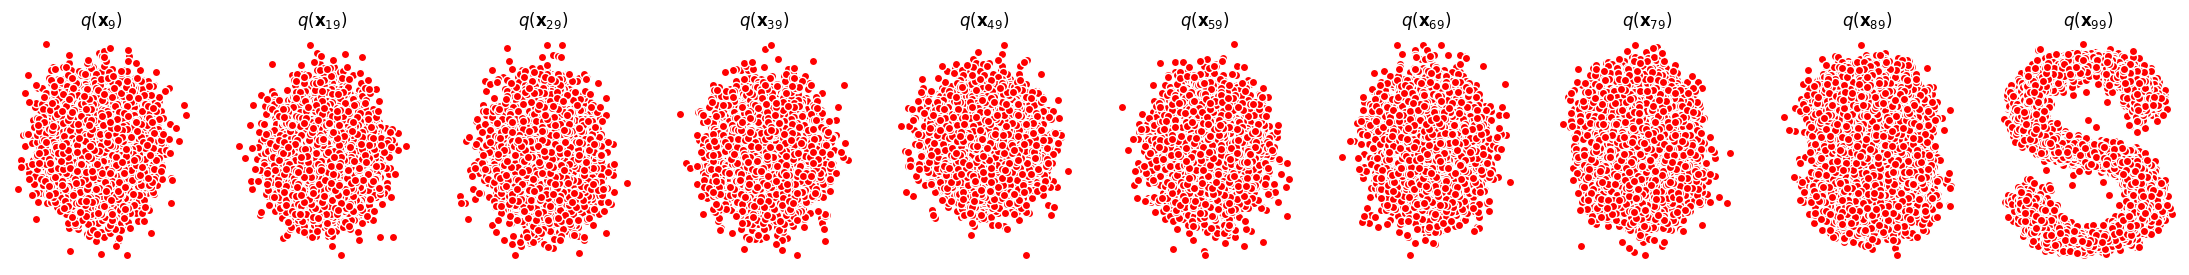

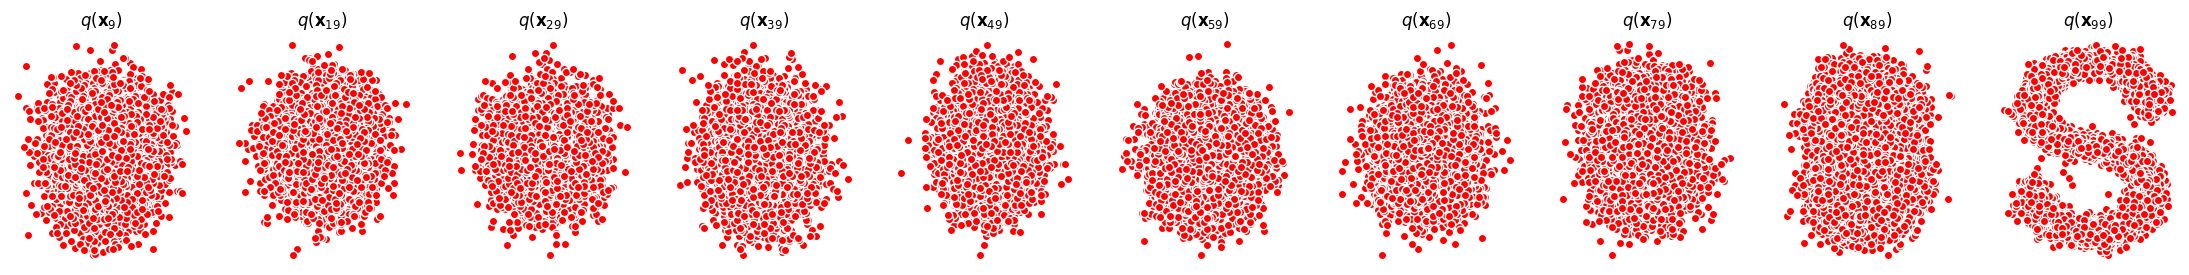

In [283]:
NUM_EPOCHS = 3000
# betas = torch.from_numpy(betas)
# alpha_bars = torch.from_numpy(alpha_bars)

for i in range(NUM_EPOCHS):
    for _, batch in enumerate(dataloader):
        loss = loss_diffusion(model, *batch_forward_diffusion(batch))
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

    if i % 100 == 0:
        print(loss)
        x_seq = p_sample_loop(model, s_curve.shape, betas, alpha_bars)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(10):
            cur_x = x_seq[i*10+9]
            axs[i].scatter(*cur_x.T, color='red', edgecolor='white')
            axs[i].set_axis_off()
            axs[i].set_title('$q(\mathbf{x}_{' + str(i * 10 + 9) + '})$')